In [ ]:
import sys
import os
sys.path.append('/home/franzi/anzeigendaten/python_base/skillextraktion/fh_ma')
sys.path.append('/home/franzi/anzeigendaten/EnvPython')
import prepare_training_data
from labels import *
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import shuffle

start = time.time()
x_train, y_train, x_test, y_test, test_afks, features = prepare_training_data.get_training_data(window=4, pos=True, word_features=True, stopwords=False, punc_marks=False)
print('took: ',time.time()-start)

In [ ]:
import numpy as np
for i,f in enumerate(features):
    features[i] = np.array(f)
pos_test, wf_test, bg_test, pos_train, wf_train, bg_train,  _, _, _ = features

print(wf_train[0]) # Abgeschlossene
print(pos_train[0]) # ADJA first


In [5]:
from tensorflow.keras import *

In [7]:
wf_test = np.reshape(wf_test, (wf_test.shape[0], wf_test.shape[2]))
wf_train = np.reshape(wf_train, (wf_train.shape[0], wf_train.shape[2]))

In [9]:
pos_test = np.reshape(pos_test, (pos_test.shape[0], pos_test.shape[2]))
pos_train = np.reshape(pos_train, (pos_train.shape[0], pos_train.shape[2]))

In [10]:
# Build the model
print('Build model...')

vector_window_input = layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
vw = layers.LSTM(256, return_sequences=True)(vector_window_input)
vw = layers.Dropout(0.5)(vw)
vw = layers.BatchNormalization()(vw)
vw = layers.LSTM(512, return_sequences=True)(vw)
vw = layers.Dropout(0.5)(vw)
vw = layers.BatchNormalization()(vw)
vw = layers.LSTM(512)(vw)
vw = layers.Dropout(0.5)(vw)
vw = layers.BatchNormalization()(vw)
vw = layers.Dense(128, activation='relu')(vw)

wf_input = layers.Input(shape=(len(wf_train[0])))
f = layers.Dense(512, activation='relu')(wf_input)
f = layers.Dropout(0.5)(f)
f = layers.Dense(256, activation='relu')(f)

pos_input = layers.Input(shape=(len(pos_train[0])))
p = layers.Dense(512, activation='relu')(pos_input)
p = layers.Dropout(0.5)(p)
p = layers.Dense(256, activation='relu')(p)

x = layers.concatenate([vw, f, p])
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)

out = layers.Dense(units=len(labels), activation='softplus')(x)
model = models.Model(inputs=[vector_window_input, wf_input, pos_input], outputs=[out])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.evaluate(x=[x_test, wf_test, pos_test], y=y_test)

batch_size=32
history = model.fit([x_train, wf_train, pos_train], y_train, batch_size=batch_size, shuffle=True, epochs=5, validation_data=([x_test, wf_test, pos_test], y_test))

Build model...
12053/12053 [==============================] - 25s 2ms/sample - loss: 2.0994 - acc: 0.0617
Train on 37823 samples, validate on 12053 samples


2020-08-19 13:27:03 WARNING: From /home/franzi/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
37823/37823 [==============================] - 200s 5ms/sample - loss: 0.7783 - acc: 0.7172 - val_loss: 0.6696 - val_acc: 0.7607
Epoch 2/5
37823/37823 [==============================] - 201s 5ms/sample - loss: 0.5877 - acc: 0.7870 - val_loss: 0.5281 - val_acc: 0.8153
Epoch 3/5
37823/37823 [==============================] - 203s 5ms/sample - loss: 0.4737 - acc: 0.8345 - val_loss: 0.4568 - val_acc: 0.8477
Epoch 4/5
37823/37823 [==============================] - 203s 5ms/sample - loss: 0.4341 - acc: 0.8506 - val_loss: 0.4353 - val_acc: 0.8517
Epoch 5/5
37823/37823 [==============================] - 204s 5ms/sample - loss: 0.4117 - acc: 0.8570 - val_loss: 0.4231 - val_acc: 0.8529


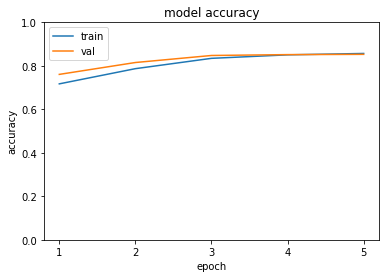

In [11]:
from matplotlib import pyplot as plt
plt.plot(np.arange(1, len(history.history['acc'])+1), history.history['acc'])
plt.plot(np.arange(1, len(history.history['acc'])+1), history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.xticks(np.arange(1, len(history.history['acc'])+1))
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [12]:
# predict test data
y_pred = model.predict([x_test, wf_test, pos_test])

In [ ]:
import numpy as np
# convert one hot to labels for test data
pred_label = prepare_training_data.one_hot_to_labels(y_pred)
true_label = prepare_training_data.one_hot_to_labels(y_test)

In [18]:
# Calc metrics for test data
import sklearn
from sklearn.metrics import precision_score, recall_score, accuracy_score
from tabulate import tabulate
label_list = list(labels.keys())

headers = [l for l in label_list ]
headers = [' '] + headers

table=[['precision'] + list(precision_score(true_label, pred_label, average=None)), 
       ['recall']+list(recall_score(true_label, pred_label, average=None)), 
       ['f1']+ list(sklearn.metrics.f1_score(true_label, pred_label, average=None))]

print(tabulate(table, headers=headers, tablefmt='orgtbl'))
f1 = sklearn.metrics.f1_score(true_label, pred_label, average=None)
f1 = np.delete(f1, 4)
f1 = np.delete(f1, 6)
print('f1 average: ',sum(sklearn.metrics.f1_score(true_label, pred_label, average=None))/len(list(precision_score(true_label, pred_label, average=None))))
print('f1 average: ',sum(f1)/6)
print('Precision average: ',sum(precision_score(true_label, pred_label, average=None)/8))
print('recall average: ',sum(recall_score(true_label, pred_label, average=None)/8))
print('acc', sklearn.metrics.accuracy_score(true_label, pred_label))

|           |   Ausbildung |   Beruf |   allgemein |   berufsspez |   Sprache |   Technologie |   Softskill |   noSkill |
|-----------+--------------+---------+-------------+--------------+-----------+---------------+-------------+-----------|
| precision |     0.806612 |       0 |    0.506    |     0.623707 |  0.980769 |      0.75983  |    0.812963 |  0.932458 |
| recall    |     0.884058 |       0 |    0.354839 |     0.73271  |  0.923077 |      0.922581 |    0.815227 |  0.917821 |
| f1        |     0.843561 |       0 |    0.417148 |     0.673829 |  0.951049 |      0.833333 |    0.814094 |  0.925081 |
f1 average:  0.6822618539983203
f1 average:  0.596994074618809
Precision average:  0.6777923447093128
recall average:  0.6937891101268113
acc 0.852899693022484


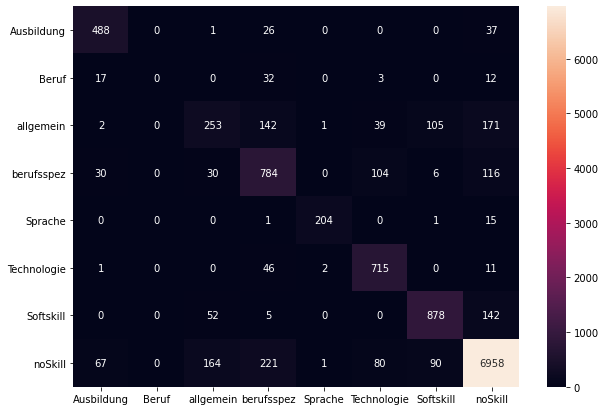

In [15]:
# Create Confusion Matrix

import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = sklearn.metrics.confusion_matrix(true_label, pred_label)
df_cm = pd.DataFrame(cm, labels,columns = labels)
plt.figure(figsize = (10,7))
plt.ylabel('Eingabe')
plt.xlabel('Ausgabe')
sn.heatmap(df_cm, annot=True,fmt='g')